# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xvf VOCtrainval_11-May-2012.tar

In [2]:
#!pip install scipy==1.1.0

### 1.1 Loading the dataset

In [3]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob


from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms



class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                print(split)
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                print(path)
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)


    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [4]:
# Modeldescription: https://www.researchgate.net/figure/Details-on-the-architectures-of-FCN8s-8-ReLU-58-and-Dropout-59-with-drop-rate_fig3_328510580

import torch.nn as nn


class FCN_8s(nn.Module):
    def __init__(self, labels=21):
        super(FCN_8s, self).__init__()
        # FCN architecture
        self.conv_1to3 = nn.Sequential(
            # 1. Convolution
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),

            # 2. Convolution
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),

            # 3. Convolution
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        )

        self.conv_4 = nn.Sequential(
            # 4. Convolution
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
        )

        self.conv_5 = nn.Sequential(
            # 5.Convolution
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
        )

        self.fully_connected = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(8, 8), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5)
        )

        self.class_fc = nn.Sequential(
            nn.Conv2d(4096, labels, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1)),
            nn.ConvTranspose2d(labels, labels, kernel_size=(4, 4), stride=(2, 2), bias=False)
        )

        self.class_fc2 = nn.Sequential(
            nn.Conv2d(labels, labels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ConvTranspose2d(labels, labels, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )

        self.pred_pool3 = nn.Conv2d(256, labels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pred_pool4 = nn.Conv2d(512, labels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.up_pred_pool4 = nn.ConvTranspose2d(labels, labels, kernel_size=(2, 2), stride=(2, 2), bias=False)
        self.up_pred8 = nn.ConvTranspose2d(labels, labels, kernel_size=(8, 8), stride=(8, 8), bias=False)

        self.softmax = nn.Softmax()


    def forward(self, x):
        out = self.conv_1to3(x)
        pool3 = out # 256 X 64 X 64

        out = self.conv_4(out)
        pool4 = out # 512 X 32 X 32

        out = self.conv_5(out) # 512 X 16 X 16
        out = self.fully_connected(out) # 4096 X 13 X 13

        up_pred2 =  self.class_fc(out) # 21 X 32 X 32

        prediction_pool4 = self.pred_pool4(pool4) # 21 X 32 X 32

        out = up_pred2 + prediction_pool4 # 21 X 32 X 32
        out = self.up_pred_pool4(out)
        up_pred4 = out # 21 x 64 x 64

        out = self.class_fc2(out) # 21 X 64 X 64
        prediction_pool3 = self.pred_pool3(pool3) # 21 x 64 x 64

        out = out + prediction_pool3 # 21 x 64 x 64
        out = self.class_fc2(out) # 21 x 64 x 64
        out = self.up_pred8(out) # 21 x 512 x 512

        out = self.softmax(out)

        return out

In [5]:
import torchvision

#Check if CUDA is available, if not use the CPU.
train_on_GPU = torch.cuda.is_available()
device = torch.device('cuda' if train_on_GPU else 'cpu')

if train_on_GPU:
    print('CUDA available!')
else:
    print('CUDA not available!')

# Creating an instance of the model defined above.
# You can modify it incase you need to pass paratemers to the constructor.

model = FCN_8s().to(device)
print(model)

#odel = torchvision.models.segmentation.fcn_resnet101(pretrained=False, progress=True, num_classes=21).to(device)
#rint(model)

CUDA available!
FCN_8s(
  (conv_1to3): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
local_path = 'data/VOCdevkit/VOC2012/' # modify it according to your device
bs = 10
epochs = 40
learning_rate = 0.001

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [7]:
# dataset variable
dst = pascalVOCDataset(root=local_path,is_transform=True)
quantity_train = len(dst)

# dataloader variable
trainloader = data.DataLoader(dst,batch_size=bs,shuffle=True)

train
data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt
val
data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt
trainval
data/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt


### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [8]:
# loss function
loss_f = nn.CrossEntropyLoss().to(device)

# optimizer variable
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 0


<ipython-input-4-495a105010f8>:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1,     1] train_loss: 3.045


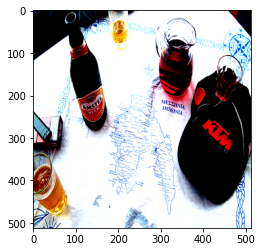

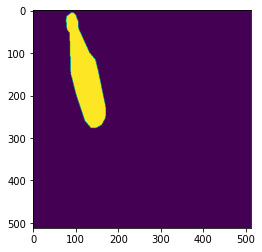

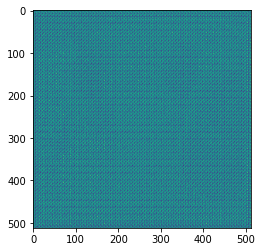

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 1


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3,     1] train_loss: 3.044


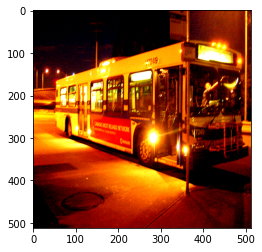

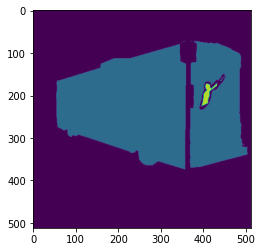

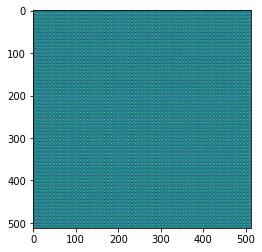

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 3


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5,     1] train_loss: nan


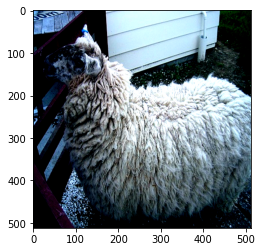

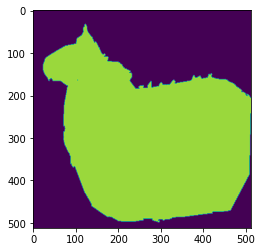

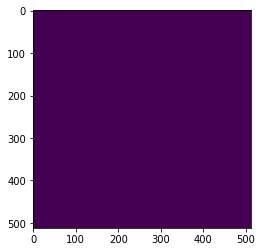

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 5


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[7,     1] train_loss: nan


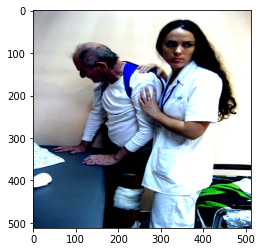

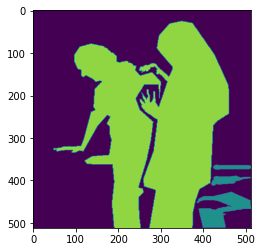

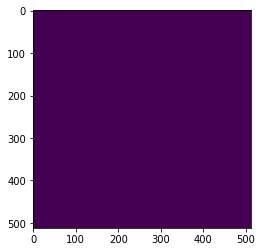

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 7


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[9,     1] train_loss: nan


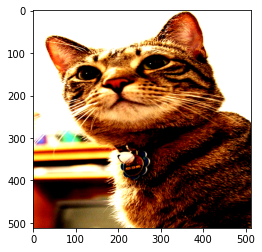

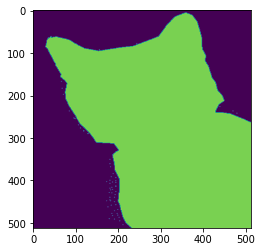

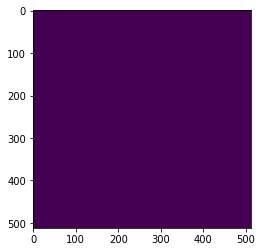

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 9


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[11,     1] train_loss: nan


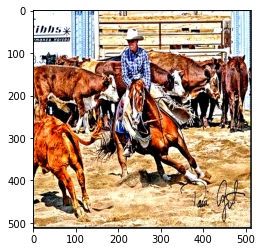

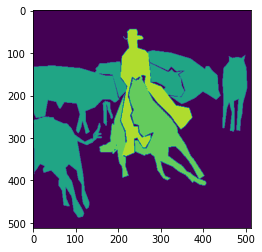

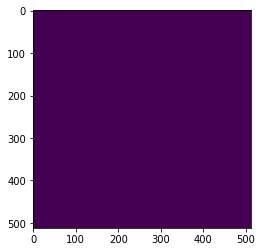

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 11


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13,     1] train_loss: nan


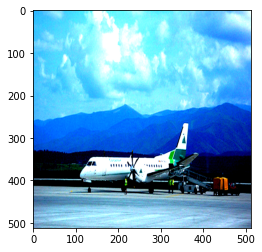

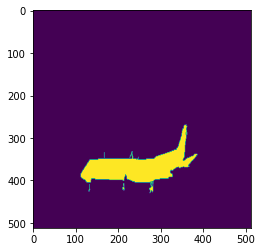

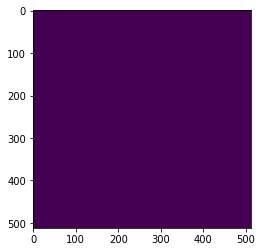

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 13


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[15,     1] train_loss: nan


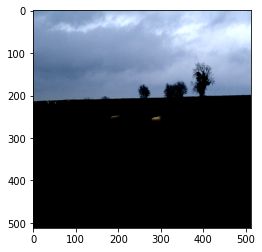

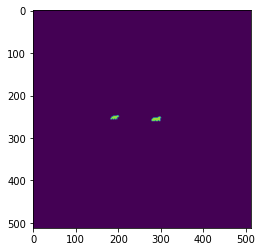

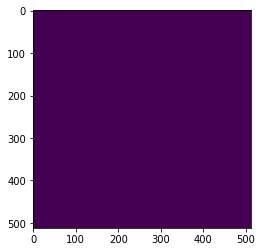

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 15


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[17,     1] train_loss: nan


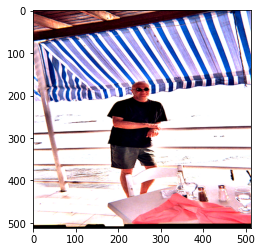

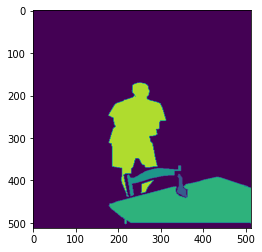

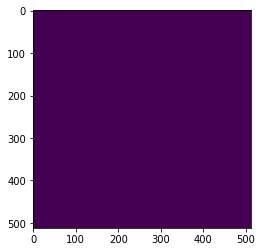

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 17


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[19,     1] train_loss: nan


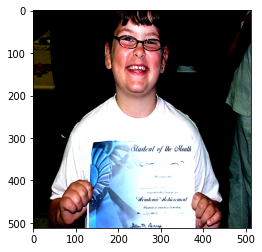

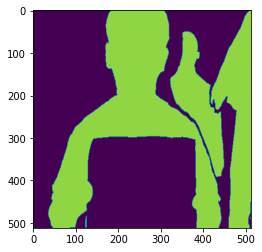

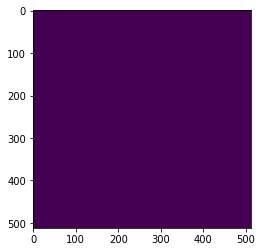

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 19


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[21,     1] train_loss: nan


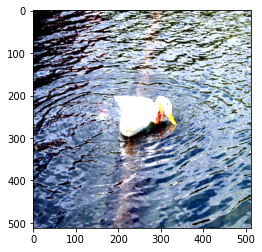

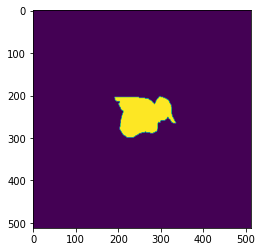

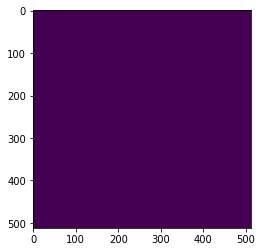

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 21


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[23,     1] train_loss: nan


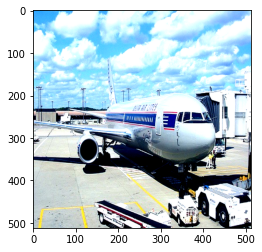

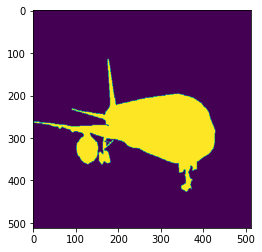

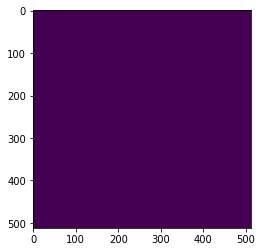

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 23


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[25,     1] train_loss: nan


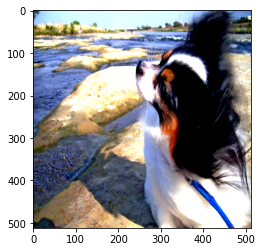

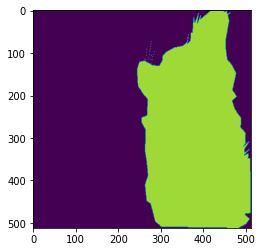

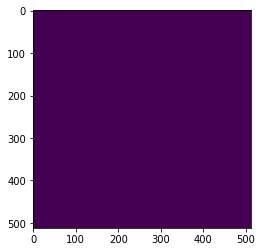

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 25


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[27,     1] train_loss: nan


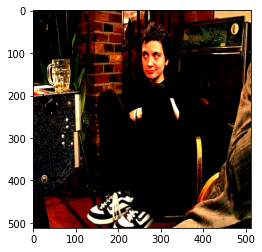

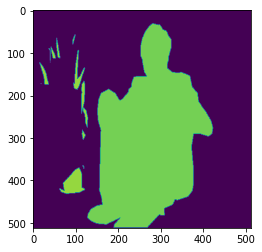

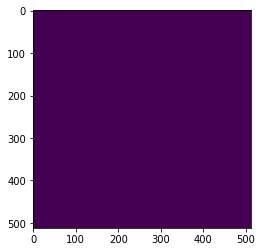

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 27


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[29,     1] train_loss: nan


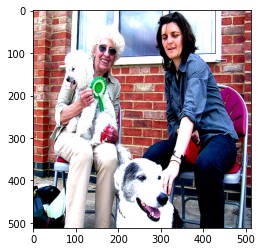

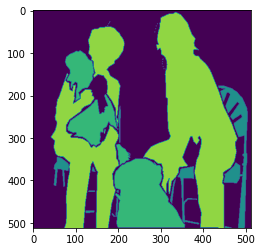

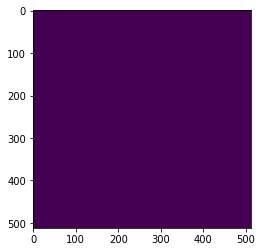

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 29


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[31,     1] train_loss: nan


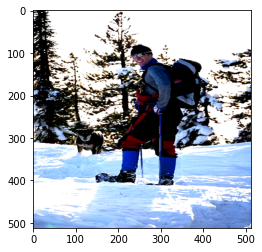

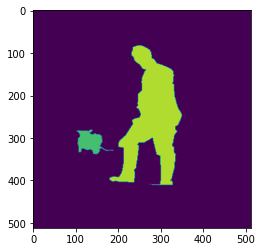

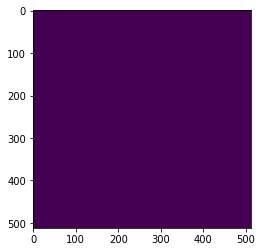

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 31


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[33,     1] train_loss: nan


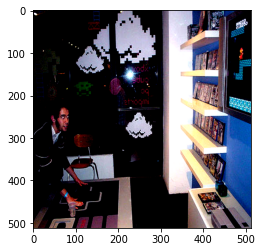

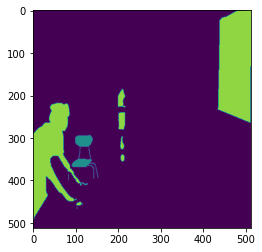

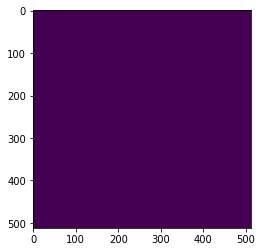

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 33


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[35,     1] train_loss: nan


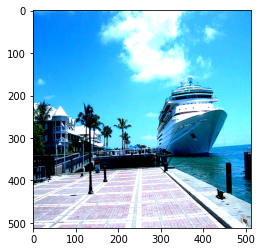

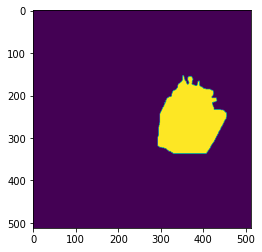

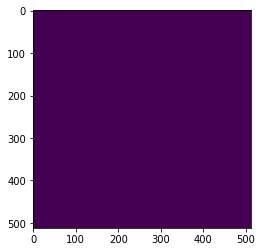

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 35


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[37,     1] train_loss: nan


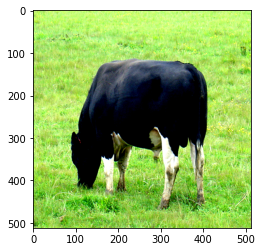

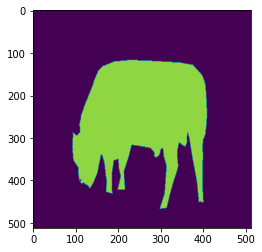

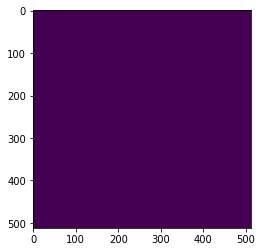

  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 37


  0%|          | 0/147 [00:00<?, ?it/s]

Training epoch: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[39,     1] train_loss: nan


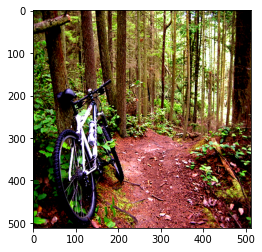

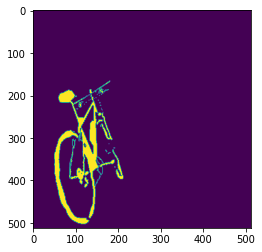

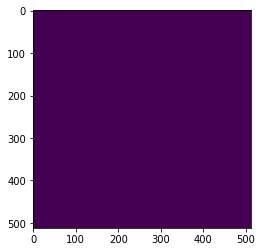

 68%|██████▊   | 100/147 [01:43<00:48,  1.04s/it, loss=nan]


KeyboardInterrupt: 

In [9]:
savedata_path = 'savedata/'
i_stats = 147
epo_stats = 2

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_statistics(epoch, batch_id, loss_actual, input_image, label_mask, output_model):
    print('[%d, %5d] train_loss: %.3f' % (epoch+1, batch_id+1, loss_actual.item()))

    # print images
    image2 = input_image.cpu()
    imshow(torchvision.utils.make_grid(image2[0]))

    label2 = label_mask.cpu()

    plt.imshow(label2.detach().numpy()[0])
    plt.show()

    output2 = output_model.cpu()
    output3 = output2.argmax(dim=1)

    plt.imshow(output3.detach().numpy()[0])
    plt.show()
    
for epo in range(0, epochs):
    filename = 'task_1_model_parameters_15032021_1332_FCN_epoch{epoch}.pt'.format(epoch=str(epo).zfill(5))

    print("Training epoch: " + str(epo))
    
    trainloader_loop = tqdm(trainloader)

    model.train()

    #if (epo+1) % 50 == 0:
    #    learning_rate *= 0.8
    #print("Learningrate: " + str(learning_rate))

    for i, (images, labels) in enumerate(trainloader_loop):
        #"Transport" the data to CUDA if available, and otherwise to the CPU
        images = images.to(device)
        labels = labels.to(device)

        #Compute the forward propagation
        with torch.cuda.amp.autocast():
            output = model(images)#['out']

            #Compute the train loss
            loss = loss_f(output, labels)

        if (i % i_stats == 0) and (epo % epo_stats == 0):
            show_statistics(epo, i, loss, images, labels, output)

        opt.zero_grad() # why?
        loss.backward()
        opt.step()

        #update tqdm
        trainloader_loop.set_postfix(loss=loss.item())

    torch.save(model.state_dict(), savedata_path + filename)

print("Finished training!")


### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
from scipy import spatial
import sklearn.metrics as metrics


def one_row(ground_truth, prediction):
    pred = prediction.view(1,-1)
    #pred = np.squeeze(pred.numpy())

    truth = ground_truth.view(1,-1)
    #truth = np.squeeze(truth.numpy())
    
    return truth[0], pred[0]#truth.astype(float), pred.astype(float)


def performance(multi_confusion_matrix, class_labels):
    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []

    for i in class_labels:
        true_positive.append(multi_confusion_matrix[i][[0],[0]][0])
        false_positive.append(multi_confusion_matrix[i][[0],[1]][0])
        true_negative.append(multi_confusion_matrix[i][[1],[1]][0])
        false_negative.append(multi_confusion_matrix[i][[1],[0]][0])

    positive = [true_positive, false_positive]
    negative = [true_negative, false_negative]

    return positive, negative


def evaluate(ground_truth, predictions):
    accuracy = 0.0
    f1 = 0
    auc_score = 0.0
    dice_coefficient = 0.0

    print("ground_truth length: " + str(len(ground_truth)))
    print("predictions length: " + str(len(predictions)))
    listlen = min(len(ground_truth),len(predictions))

    for l in range(0, listlen):
        x = ground_truth[l].cpu()
        y = predictions[l].cpu()

        transform_tensors = one_row(x, y)

        class_labels = list(range(0, 21))

        multi_confusion_matrix = metrics.multilabel_confusion_matrix(transform_tensors[0], transform_tensors[1], labels=class_labels)

        performance_model = performance(multi_confusion_matrix, class_labels)

        positives = performance_model[0]
        negatives = performance_model[1]

        positives_total, negatives_total = 0,0
        true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0

        for i in class_labels:
            positives_total += positives[0][i] + positives[1][i]
            negatives_total += negatives[0][i] + negatives[1][i]

            true_positives += positives[0][i]
            false_positives += positives[1][i]
            true_negatives += negatives[0][i]
            false_negatives += negatives[1][i]

        # Accuracy
        if (positives_total + negatives_total) != 0:
            accuracy += (true_positives + true_negatives) / (positives_total + negatives_total)


        # F1 score
        f1 = metrics.f1_score(transform_tensors[0], transform_tensors[1], average='micro')
        #f1 = []
        #for i in class_labels:
        #    denominator = 2 * positives[0][i] + positives[1][i] + negatives[1][i]
        #    if denominator != 0:
        #        f1.append(2 * positives[0][1] / denominator)
        #    else:
        #        f1.append(0.0)

        #f1_score += f1


        # AUC-ROC score
        #auc_score += metrics.roc_auc_score(transform_tensors[0], transform_tensors[1], multi_class='ovr', labels=class_labels)


        # DICE coefficient
        if (2 * true_positives + false_positives + false_negatives) != 0:
            dice_coefficient += (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)


    accuracy = accuracy / listlen
    #f1_score = f1_score / listlen
    auc_score = auc_score / listlen
    dice_coefficient = dice_coefficient / listlen

    return accuracy, f1, auc_score, dice_coefficient


### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
breaker = True

with torch.no_grad():
    trainloader_loop = tqdm(trainloader)

    if breaker:
        model.eval()
        accuracy = []
        f1_score = []
        auc_roc = []
        dice = []
        for epo in range(epochs):
            ground_truth, predictions = [], []
            # load weights from file
            filename = 'task_1_model_parameters_15032021_1332_FCN_epoch{epoch}.pt'.format(epoch=str(epo).zfill(5))
            pretrained_weights = torch.load(savedata_path + filename)
            model.load_state_dict(pretrained_weights)
            for i,data in enumerate(trainloader_loop):
                x = data[0].to(device)
                y = data[1].cpu()

                prediction = model(x).argmax(dim=1)
                #prediction = model(x)['out']

                #if i>2:
                #    break
                
                ground_truth.append(y.float())
                predictions.append(prediction.float())
            print("starting evaluation for epoch " + str(epo))
            eval = evaluate(ground_truth, predictions)
            print("finsihed evaluation for epoch " + str(epo))
            accuracy.append(eval[0])
            f1_score.append(eval[1])
            auc_roc.append(eval[2])
            dice.append(eval[3])
            del x
            del y


#Plot the train loss function
plt.title("Loss during the training of the CNN")
plt.plot(accuracy,'-b',label='Accuracy')
plt.plot(f1_score,'-r',label='F1 Score')
plt.plot(auc_roc,'-g',label='AUC-ROC Score')
plt.plot(dice,'-b',label='DICE Score')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [ ]:
model.eval()

trainloader_loop = tqdm(trainloader)

for i, batch in enumerate(trainloader_loop):
    if i % 10 == 0:
        img = batch[0]
        lab = batch[1].cpu()

        img2 = img.cpu()
        imshow(torchvision.utils.make_grid(img2[0]))

        plt.imshow(lab.detach().numpy()[0])
        plt.show()

        with torch.no_grad():
            pred = model(img.to(device)).cpu()
            #pred = model(img.to(device))['out'].cpu()

        pred = pred.argmax(dim=1)
        plt.imshow(pred.detach().numpy()[0])
        plt.show()

